# Analyse des données sur la varicelle

In [1]:
import os
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import isoweek

%matplotlib inline
plt.style.use('ggplot')

## Chargement des données

Nous utilisons pour cette analyse les données de surveillance continue du **Réseau Sentinelles** en France. Nous récupérons depuis la base de données en ligne le fichier au format csv contenant les données complètes sur **l'incidence hebdomadaire de la varicelle en France métropolitaine** (depuis 1991 jusqu'à la semaine la plus récente disponible). 

Nous avons téléchargé le fichier le 2025/08/27 depuis l'URL suivante : https://www.sentiweb.fr/datasets/all/inc-7-PAY.csv.
Le code qui suit permet de récupérer le fichier en le téléchargeant directement depuis l'URL uniquement si le fichier n'est pas déjà présent localement. 

In [2]:
data_file = "inc-7-PAY.csv"
data_url = "https://www.sentiweb.fr/datasets/all/inc-7-PAY.csv"

if not os.path.exists(data_file):
    urllib.request.urlretrieve(data_url, data_file)
    
data = pd.read_csv("inc-7-PAY.csv", skiprows = 1)
data.head()

week  indicator   inc  inc_low  inc_up  inc100  inc100_low  inc100_up  \
0  202534          7  1856       95    3617       3           0          6   
1  202533          7  3627      718    6536       5           1          9   
2  202532          7  2384        0    4809       4           0          8   
3  202531          7  5703        0   13082       9           0         20   
4  202530          7  7102     3590   10614      11           6         16   

  geo_insee geo_name  
0        FR   France  
1        FR   France  
2        FR   France  
3        FR   France  
4        FR   France

Voici l'explication des colonnes données [sur le site du Réseau Sentinelles](https://ns.sentiweb.fr/incidence/json-schema-v1.json) :

| Nom de colonne | Libellé de colonne |
|----------------|-----------------------------------------------------------------------------------------------------------------------------------|
| week           | Semaine calendaire (ISO 8601) |
| indicator      | Code de l'indicateur de surveillance |
| inc            | Estimation de l'incidence de consultations en nombre de cas |
| inc_low        | Estimation de la borne inférieure de l'IC95% du nombre de cas de consultation |
| inc_up         | Estimation de la borne supérieure de l'IC95% du nombre de cas de consultation |
| inc100         | Estimation du taux d'incidence du nombre de cas de consultation (en cas pour 100,000 habitants) |
| inc100_low     | Estimation de la borne inférieure de l'IC95% du taux d'incidence du nombre de cas de consultation (en cas pour 100,000 habitants) |
| inc100_up      | Estimation de la borne supérieure de l'IC95% du taux d'incidence du nombre de cas de consultation (en cas pour 100,000 habitants) |
| geo_insee      | Code de la zone géographique concernée (Code INSEE) http://www.insee.fr/fr/methodes/nomenclatures/cog/ |
| geo_name       | Libellé de la zone géographique (ce libellé peut être modifié sans préavis) |

La première ligne étant un commentaire, nous avons indiqué à Pandas de l'ignorer dans notre code à l'aide de l'argument `skiprows = 1`.

## Contrôle des données

Nous vérifions dans un premier temps s'il existe des données manquantes. Il semblerait qu'aucune ligne n'ait de données manquantes.

In [3]:
data[data.isnull().any(axis = 1)]
data.isnull().any()

week          False
indicator     False
inc           False
inc_low       False
inc_up        False
inc100        False
inc100_low    False
inc100_up     False
geo_insee     False
geo_name      False
dtype: bool

Comme dans l'exemple du syndrome grippal, nous avons besoin de convertir les dates en un format compréhensible par Pandas.

In [4]:
 def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

data['period'] = [convert_week(yw) for yw in data['week']]
data.head()

week  indicator   inc  inc_low  inc_up  inc100  inc100_low  inc100_up  \
0  202534          7  1856       95    3617       3           0          6   
1  202533          7  3627      718    6536       5           1          9   
2  202532          7  2384        0    4809       4           0          8   
3  202531          7  5703        0   13082       9           0         20   
4  202530          7  7102     3590   10614      11           6         16   

  geo_insee geo_name                period  
0        FR   France 2025-08-18/2025-08-24  
1        FR   France 2025-08-11/2025-08-17  
2        FR   France 2025-08-04/2025-08-10  
3        FR   France 2025-07-28/2025-08-03  
4        FR   France 2025-07-21/2025-07-27

Nous définissons ici aussi les périodes d’observation comme index du jeu de données pour en faire une suite chronologique, et pouvoir trier les points par période dans l'ordre chronologique.

In [5]:
sorted_data = data.set_index('period').sort_index()
sorted_data.head()

week  indicator    inc  inc_low  inc_up  inc100  \
period                                                                     
1990-12-03/1990-12-09  199049          7   1143        0    2610       2   
1990-12-10/1990-12-16  199050          7  11079     6660   15498      20   
1990-12-17/1990-12-23  199051          7  19080    13807   24353      34   
1990-12-24/1990-12-30  199052          7  19375    13295   25455      34   
1990-12-31/1991-01-06  199101          7  15565    10271   20859      27   

                       inc100_low  inc100_up geo_insee geo_name  
period                                                           
1990-12-03/1990-12-09           0          5        FR   France  
1990-12-10/1990-12-16          12         28        FR   France  
1990-12-17/1990-12-23          25         43        FR   France  
1990-12-24/1990-12-30          23         45        FR   France  
1990-12-31/1991-01-06          18         36        FR   France

Il nous reste à vérifier la cohérence des données au niveau des périodes définies. Entre la fin d’une période et le début de la période qui suit, la différence temporelle doit être très proche de zéro. Ici rien à signaler !

In [6]:
periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

## Visualisation des données

On peut maintenant regarder le taux d'incidence sur toute la période mesurée.

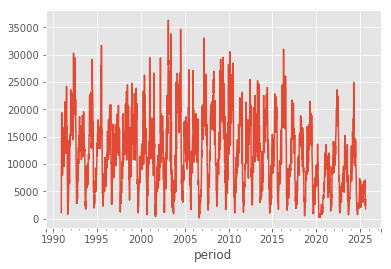

In [7]:
sorted_data['inc'].plot()
plt.show()

Le plot est un peu compliqué à lire avec tant de données. Zoomons donc sur les dernières années.

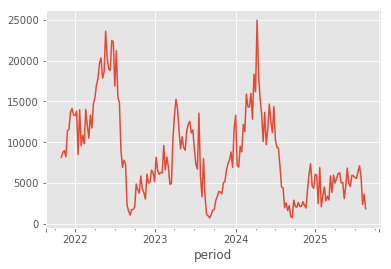

In [8]:
sorted_data['inc'][-200:].plot()
plt.show()

A première vue nous ne distinguons pas un pattern aussi clair que lors de l'analyse précédente sur le syndrome grippal.

## Etude de l'incidence annuelle

 Nous choisissons le 1er septembre comme début de chaque période annuelle, et nous commençons l'analyse à la première année complète, c'est-à-dire en 1991.

In [9]:
first_september_weeks = [pd.Period(pd.Timestamp(y, 9, 1), 'W')
for y in range(1991, sorted_data.index[-1].year)]
len(first_september_weeks)

34

Petit contrôle de cohérence pour vérifier que les périodes définies contiennent bien entre 51 et 52 semaines. 

In [10]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_september_weeks[:-1], first_september_weeks[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data = yearly_incidence, index = year)
yearly_incidence.head()

1992    832939
1993    643387
1994    661409
1995    652478
1996    564901
dtype: int64

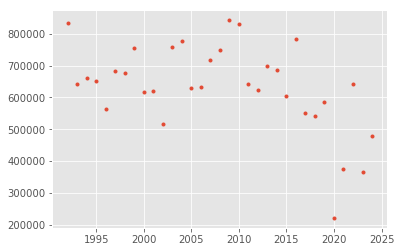

In [11]:
yearly_incidence.plot(style = '.')
plt.show()

On a déjà une idée de quelles années ont eu l'incidence la plus forte. Et on peut aussi remarquer que l'incidence (reportée en tout cas) a été particulièrement faible en 2020, année de COVID et confinements...

Regardons les plus fortes incidences :

In [12]:
yearly_incidence.sort_values(ascending = False)[0:5,]

2009    842373
1992    832939
2010    829911
2016    782114
2004    777388
dtype: int64

Puis les plus faibles :

In [13]:
yearly_incidence.sort_values()[0:5,]

2020    221186
2023    366227
2021    376290
2024    479258
2002    516689
dtype: int64

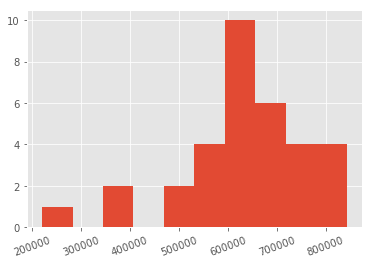

In [14]:
yearly_incidence.hist(xrot=20)
plt.show()